In [ ]:
#Spark
import findspark
import pyspark

findspark.init()
sc = pyspark.SparkContext()

In [72]:
from pyspark.sql.types import *
from pyspark.sql import Row
import pyspark.sql.functions as F

import pandas as pd; import seaborn as sns
from datetime import datetime;
import json, sys, datetime

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### AWS Athena query on `changesets` table: 

```sql
SELECT   id,
         uid,
         "user",
         num_changes,
         date(created_at) AS date,
         tags['imagery_used'] AS imagery_used, 
         tags['hashtags'] AS hashtags, -- this used to be a JSON array but spark doesn't like that
         tags['comment'] AS comment,
         tags['created_by'] AS created_by, 
         min_lat, max_lat, min_lon, max_lon
FROM changesets
WHERE tags['imagery_used'] is NOT null
      AND created_at > date '2015-01-01'
ORDER BY  date(created_at) DESC 
```

In [73]:
#Start the sqlContext
sqlContext = pyspark.SQLContext(sc)

In [74]:
#Start with the since-2018 edits
schema = StructType() \
      .add("id",IntegerType(),True) \
      .add("uid",IntegerType(),True) \
      .add("user",StringType(),True) \
      .add("num_changes",IntegerType(),True) \
      .add("date",StringType(),True) \
      .add("imagery_used",StringType(),True) \
      .add("comment",StringType(),True) \
      .add("created_by",StringType(),True) \
      .add("min_lat",FloatType(),True) \
      .add("max_lat",FloatType(),True) \
      .add("min_lon",FloatType(),True) \
      .add("max_lon",FloatType(),True)
    
changesets = sqlContext.read.format("csv") \
                .option("header",True) \
                .schema(schema) \
                .load("csv/*.csv")

#ignoring this:       .add("hashtags", ArrayType(StringType(), True), True) \

In [75]:
changesets.dtypes

[('id', 'int'),
 ('uid', 'int'),
 ('user', 'string'),
 ('num_changes', 'int'),
 ('date', 'string'),
 ('imagery_used', 'string'),
 ('comment', 'string'),
 ('created_by', 'string'),
 ('min_lat', 'float'),
 ('max_lat', 'float'),
 ('min_lon', 'float'),
 ('max_lon', 'float')]

In [76]:
changesets.tail(1)

[Row(id=27839551, uid=2524190, user='jojopi', num_changes=32, date='2015-01-01', imagery_used=None, comment=None, created_by='Adding Nodes and ways', min_lat=None, max_lat=50.8824577331543, min_lon=50.88423538208008, max_lon=8.81818962097168)]

In [77]:
#Convert the date string to a real date
changesets = changesets.withColumn('date',F.to_date(changesets.date, 'yyyy-MM-dd'))

In [78]:
#Extract just the year for easier grouping
changesets = changesets.withColumn('year',F.year(F.col('date')))

In [79]:
#Filter for only rows with imagery
changesets_with_imagery = changesets.filter(F.col('imagery_used').isNotNull())

In [80]:
changesets_with_imagery.count()

31564260

In [81]:
def imagery_classifier(imagery_used_string):
    lower_string = imagery_used_string.lower()

    if 'bing' in lower_string:
        return 'microsoft'

    if 'esri' in lower_string:
        return 'esri'

    if 'mapbox' in lower_string:
        return 'mapbox'

    if 'maxar' in lower_string or 'digitalglobe' in lower_string:
        return 'maxar'

    if 'bdortho ign' in lower_string:
        return 'BDOrtho IGN'

    if 'pnoa spain' in lower_string:
        return 'PNOA Spain'

    else:
        return 'unclassified'

    return res

from pyspark.sql.types import StringType
imagery_classifier_udf = F.udf(lambda z: imagery_classifier(z), StringType())

In [82]:
changesets_with_imagery = changesets_with_imagery.withColumn('source', imagery_classifier_udf(F.col('imagery_used')))

In [83]:
changesets_with_imagery.take(3)

[Row(id=55058628, uid=6254087, user='xyz321', num_changes=10, date=datetime.date(2017, 12, 31), imagery_used='Bing aerial imagery', comment=None, created_by='.', min_lat=None, max_lat=47.751502990722656, min_lon=47.759307861328125, max_lon=18.6931209564209, year=2017, source='microsoft'),
 Row(id=55058629, uid=77947, user='Roman Guy', num_changes=204, date=datetime.date(2017, 12, 31), imagery_used='Bing aerial imagery', comment=None, created_by='BE, Dour, r R Tachenion, ad landuses & buildings', min_lat=None, max_lat=50.40652847290039, min_lon=50.416683197021484, max_lon=3.7438926696777344, year=2017, source='microsoft'),
 Row(id=55058631, uid=2644617, user='Jimiiee', num_changes=65, date=datetime.date(2017, 12, 31), imagery_used='PDOK Luchtfoto Beeldmateriaal 25cm', comment=None, created_by='split 1 large tennis court into multiple smaller ones, also added forest', min_lat=None, max_lat=51.86683654785156, min_lon=51.86908721923828, max_lon=4.466648578643799, year=2017, source='unclass

In [84]:
# This is the number of changesets we'll have to ignore for parsing errors
changesets_with_imagery.filter(F.col('year').isNull()).count()

61103

In [85]:
gb_year = changesets_with_imagery.filter(F.col('year').isNotNull()) \
   .groupby(['year','source']).agg(
      F.countDistinct('uid'),
      F.sum('num_changes'),
      F.count('id')).toPandas()
gb_year.head(3)

,year,source,count(uid),sum(num_changes),count(id)
0,2017,mapbox,14728,15202848,251780
1,2016,mapbox,10863,11271961,205176
2,2020,PNOA Spain,2716,3259064,50772


In [86]:
# A little cleaning
gb_year.year = gb_year.year.apply(int)

In [87]:
gb_year.head(3)

,year,source,count(uid),sum(num_changes),count(id)
0,2017,mapbox,14728,15202848,251780
1,2016,mapbox,10863,11271961,205176
2,2020,PNOA Spain,2716,3259064,50772


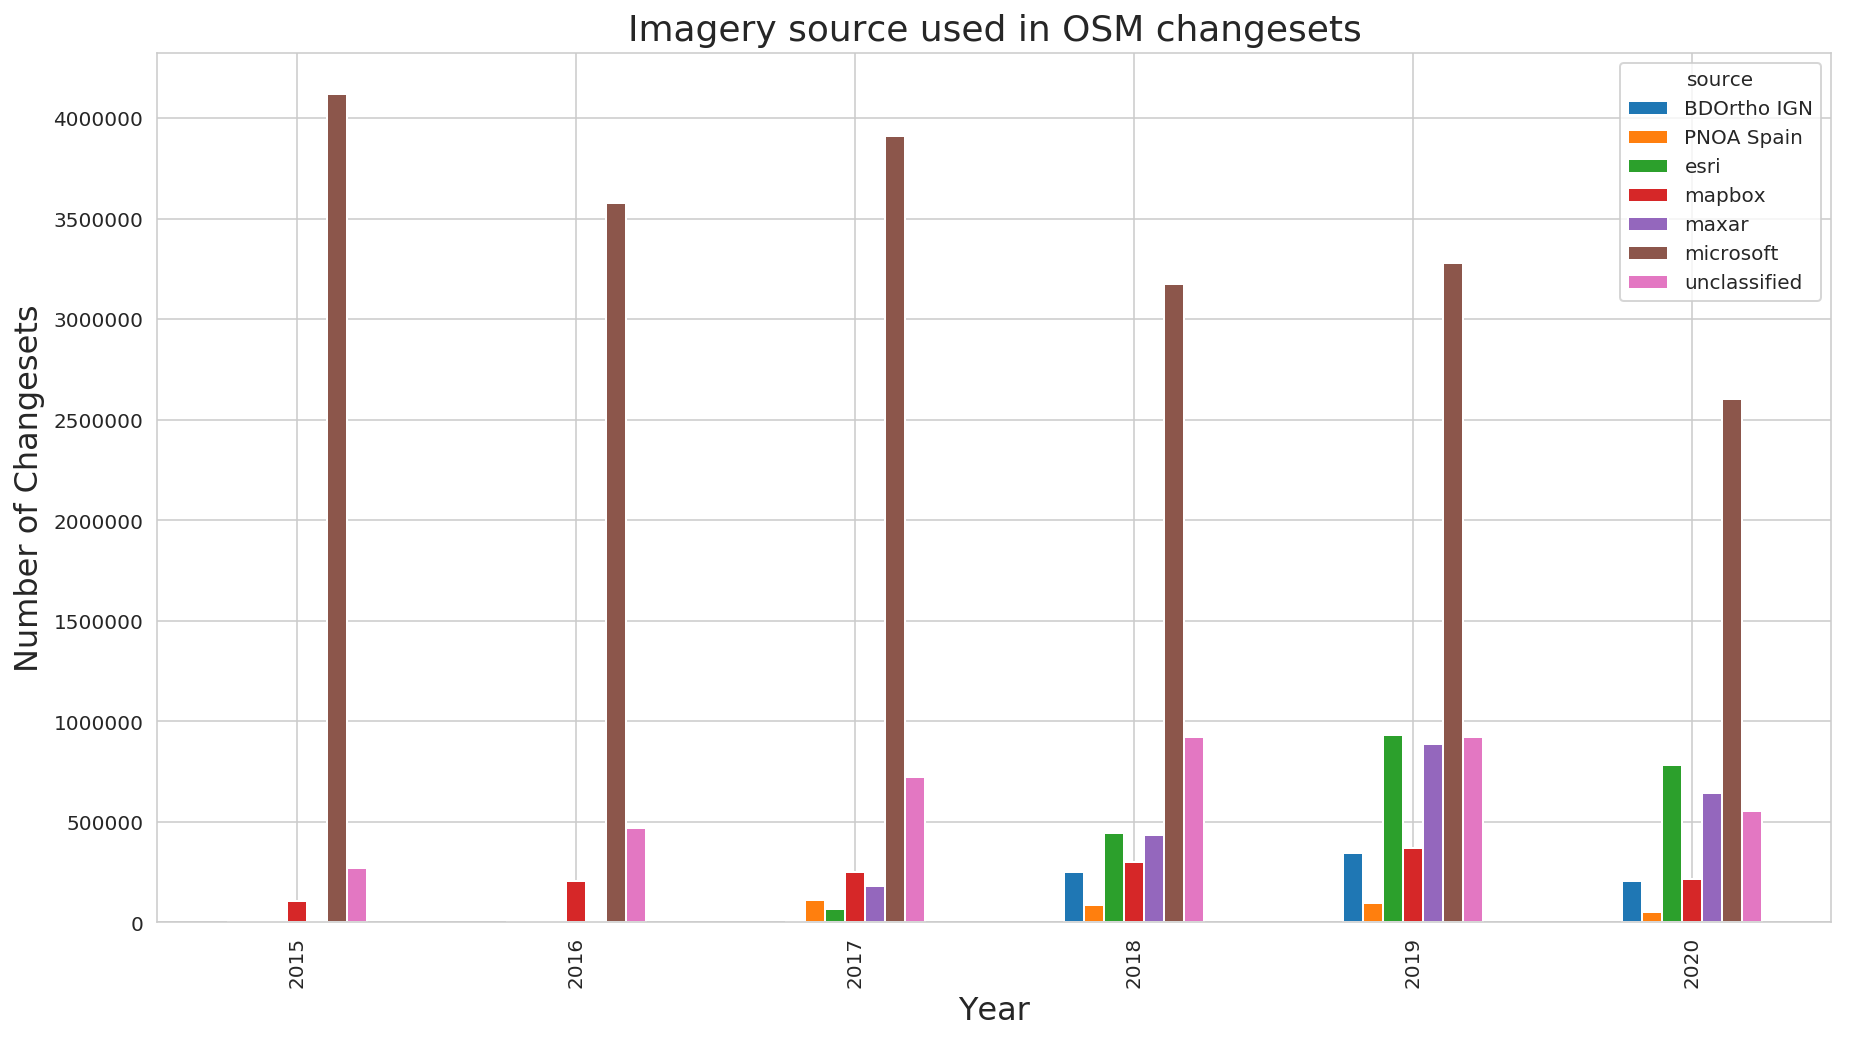

In [88]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['count(id)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Changesets',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

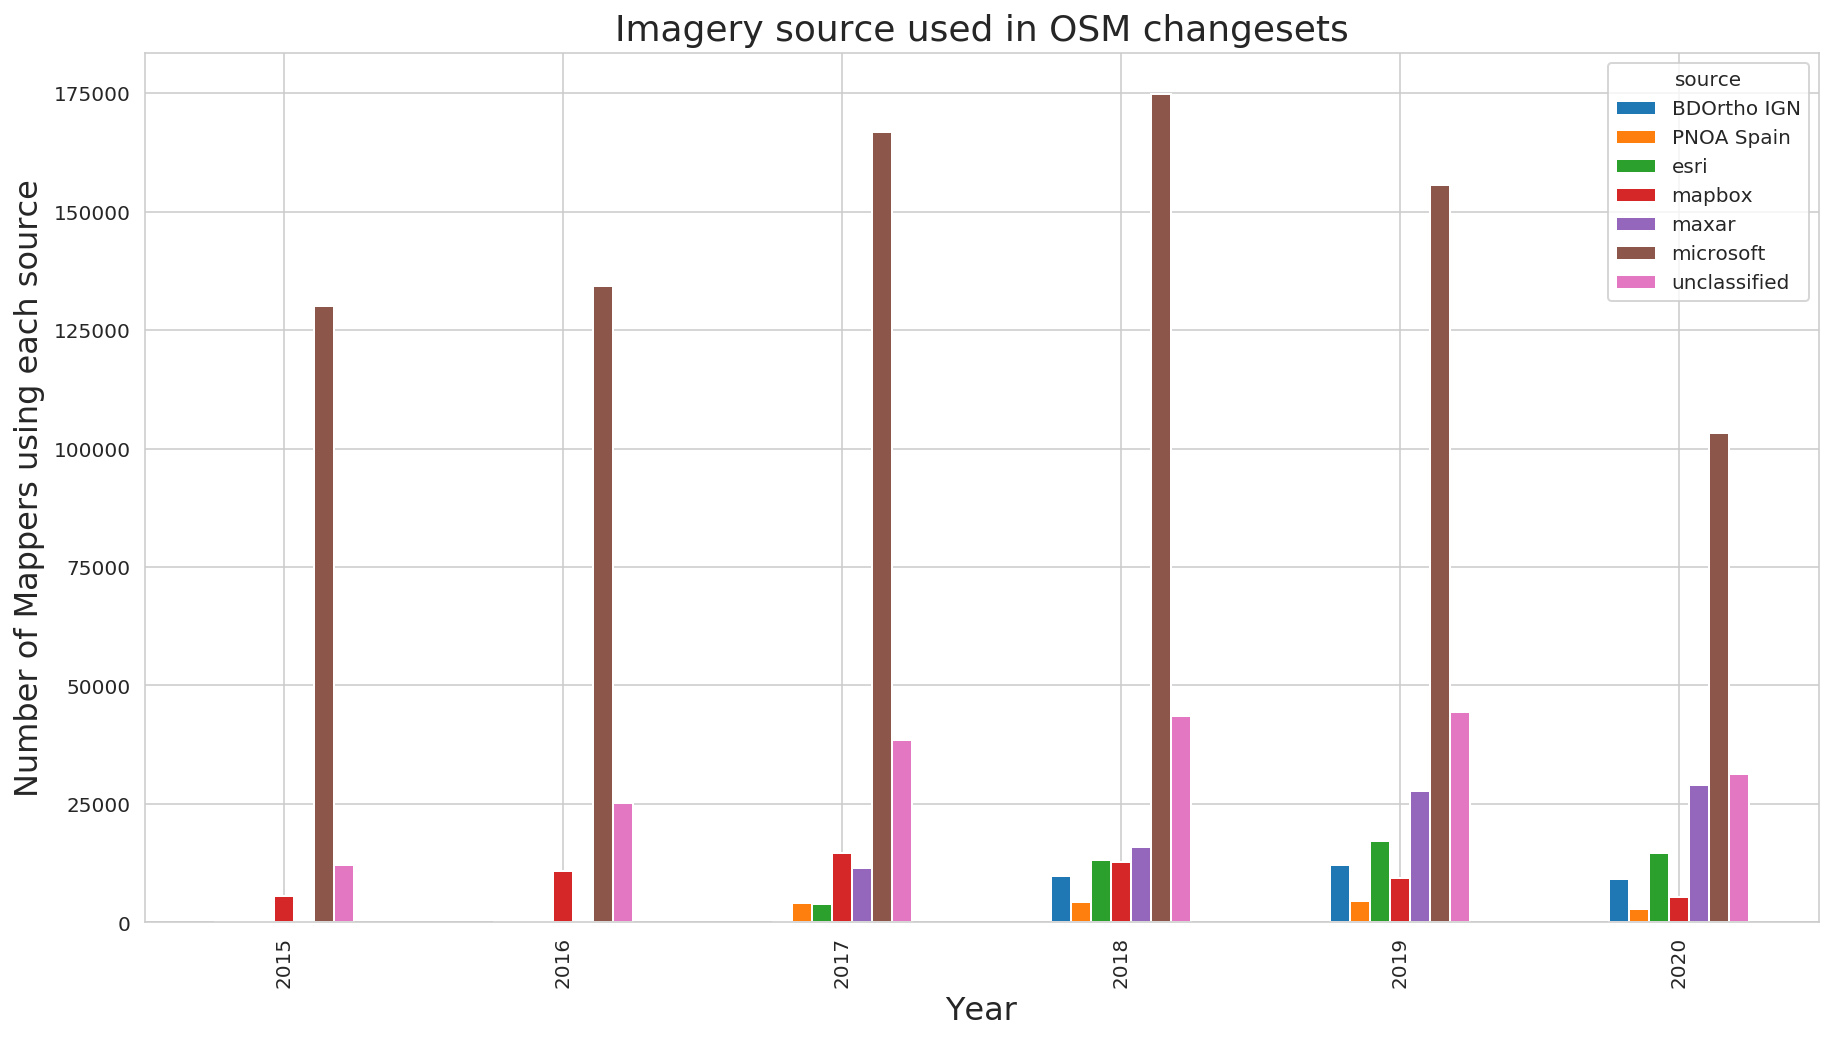

In [89]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['count(uid)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Mappers using each source',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

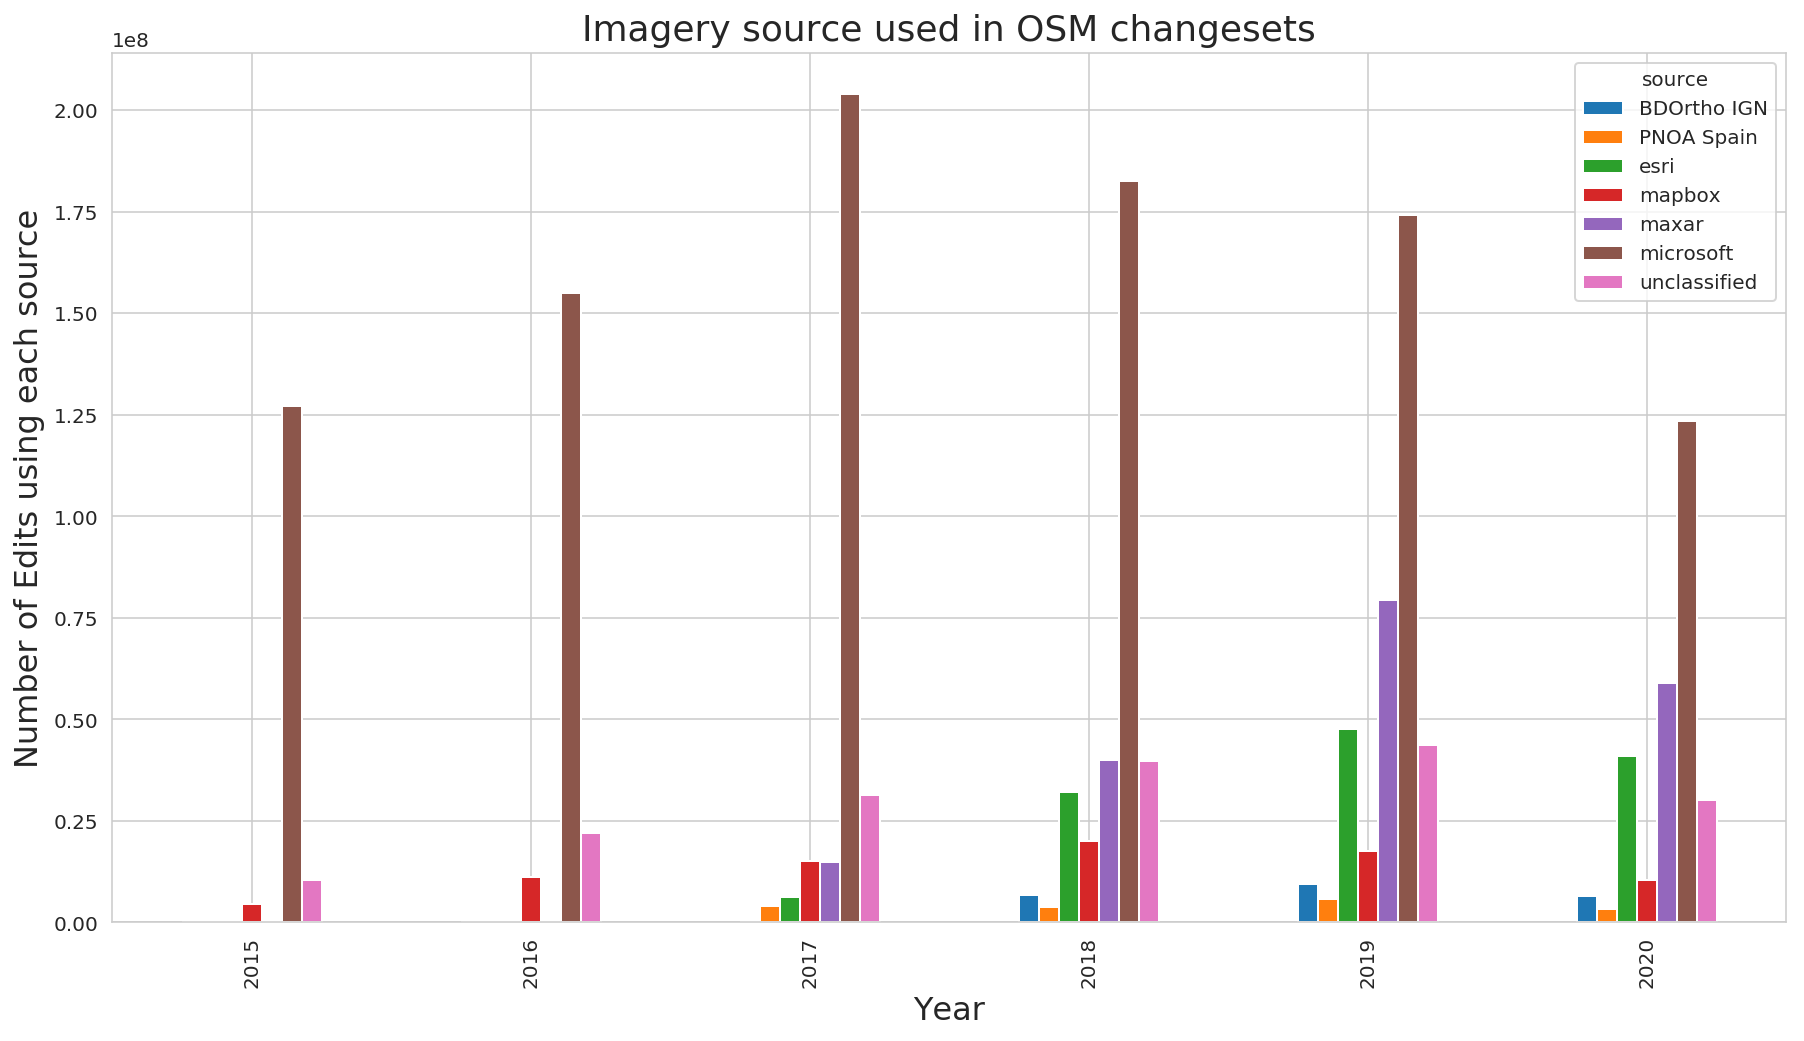

In [90]:
sns.set_style('whitegrid')
ax = gb_year.set_index(['year','source']).unstack()['sum(num_changes)'].plot(figsize=(15,8), kind='bar')

ax.set_xlabel("Year",fontsize=16); ax.set_ylabel('Number of Edits using each source',fontsize=16);
ax.set_title("Imagery source used in OSM changesets", fontsize=18);

<br><br><br><br><hr>

Tried this earlier, but since moved to PySpark
```python
import re
# What are some of the other regular expressions? 
bing   = re.compile('bing', re.IGNORECASE)
esri   = re.compile('esri', re.IGNORECASE)
tiger  = re.compile('tiger', re.IGNORECASE)
maxar  = re.compile('digitalglobe|maxar', re.IGNORECASE)
mapbox = re.compile('mapbox', re.IGNORECASE)

df['bing']   = df.imagery_used.progress_apply(lambda s: True if bing.match(s) else False)
df['esri']   = df.imagery_used.progress_apply(lambda s: True if esri.match(s) else False)
df['tiger']  = df.imagery_used.progress_apply(lambda s: True if tiger.match(s) else False)
df['maxar']  = df.imagery_used.progress_apply(lambda s: True if maxar.match(s) else False)
df['mapbox'] = df.imagery_used.progress_apply(lambda s: True if mapbox.match(s) else False)
```